## AIAP 14: Assessment 2

About: Fishing company (client) require AI engineer (ie: me) to come up with ML model to predict the likelihood of rain the following day, based on given set of attributes that include location, evaporation, sunshine, amongst other factors. Additionally, client also specified that a day is considered to be rainy when rainfall is >1.0mm for that day. The goal of this exercise is to assess which attributes has more significant predictive value in determining likelihood of rain, using at least 3 machine learning models.

### Import libraries

1. Import libraries required for data engineering and plotting graphs
2. Import libraries from src (self-created), containing functions for data engineering and graph visualisation
3. Import libraries for class imbalance
4. Import libraries for train test split and cross validation
5. Import libraries for machine learning

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import pingouin as pg


c:\Users\Han\AppData\Local\Programs\Python\Python38\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (5.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
from src.db_conn import ConnectToDB
from src.preprocess import *
from src.eda_vis import *
from src.train_test_split import *
from src.modelview import *

In [3]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [4]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.feature_selection import RFECV

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier, RidgeClassifierCV 
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

Open database file by calling "read_sql_query" from pandas. Important attributes to take note are:

- Number of rows and columns in dataframe
- Call df.info to view number of non-null values and dtypes
- Call df.describe to get quick idea of minimum, mean, standard deviation, max values of each attribute

In [8]:
pathtodb = 'data/fishing.db'

df = pd.read_sql_query("SELECT * from fishing", ConnectToDB(pathtodb))

# Display dataframe from SQL file
df

Database created and Successfully Connected to SQLite


,Date,Location,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,RainToday,RainTomorrow,ColourOfBoats,AverageTemp
0,2009-03-08,Changi,0.0,7.0,11.2,E,35.0,E,ESE,15.0,...,60.0,54.0,MED,Med,4.0,5.0,No,No,blue,33.4
1,2014-11-12,Woodlands,0.0,8.4,9.6,WNW,37.0,NNE,NW,13.0,...,60.0,56.0,MeD,LOw,1.0,2.0,None,Yes,blue,35.4
2,2008-08-08,Woodlands,0.0,7.6,11.1,ESE,52.0,SE,E,19.0,...,NaN,13.0,Med,MEd,0.0,0.0,None,No,blue,32.8
3,2015-10-12,Changi,0.0,7.2,11.4,NE,31.0,NNW,NE,9.0,...,51.0,53.0,hIgh,med,1.0,1.0,No,No,red,31.4
4,2013-10-27,Woodlands,5.6,7.0,8.5,NNW,33.0,N,N,13.0,...,68.0,64.0,meD,MeD,6.0,5.0,None,No,grey,35.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12992,2015-06-12,Tuas,0.4,1.6,5.6,SW,28.0,None,SW,0.0,...,92.0,66.0,MEd,mED,4.0,3.0,No,No,red,29.3
12993,2016-09-29,Changi,0.0,7.4,0.6,NNW,35.0,N,NNW,4.0,...,57.0,48.0,LOw,LoW,7.0,8.0,No,Yes,white,31.3
12994,2011-05-14,Sentosa,8.0,0.8,5.4,S,52.0,WSW,S,24.0,...,87.0,64.0,HiGH,HIgH,NaN,NaN,Yes,Yes,grey,26.4
12995,2011-02-14,Sentosa,4.4,4.4,12.0,S,31.0,SSE,SSE,13.0,...,68.0,52.0,hiGH,hIgh,5.0,1.0,Yes,No,blue,30.5


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12997 entries, 0 to 12996
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           12997 non-null  object 
 1   Location       12997 non-null  object 
 2   Rainfall       12997 non-null  float64
 3   Evaporation    12917 non-null  float64
 4   Sunshine       12939 non-null  float64
 5   WindGustDir    12913 non-null  object 
 6   WindGustSpeed  12917 non-null  float64
 7   WindDir9am     12697 non-null  object 
 8   WindDir3pm     12945 non-null  object 
 9   WindSpeed9am   12992 non-null  float64
 10  WindSpeed3pm   12991 non-null  float64
 11  Humidity9am    12983 non-null  float64
 12  Humidity3pm    12970 non-null  float64
 13  Pressure9am    12995 non-null  object 
 14  Pressure3pm    12989 non-null  object 
 15  Cloud9am       12693 non-null  float64
 16  Cloud3pm       12615 non-null  float64
 17  RainToday      9799 non-null   object 
 18  RainTo

In [10]:
df.describe()

,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Cloud9am,Cloud3pm,AverageTemp
count,12997.000000,12917.000000,12939.000000,12917.000000,12992.000000,12991.000000,12983.000000,12970.000000,12693.000000,12615.000000,12988.000000
mean,3.040532,5.551955,6.496236,36.640164,12.456974,16.703102,65.476623,50.818813,4.108879,4.124138,31.522144
std,10.958255,2.898708,6.026236,12.628845,8.341814,7.882508,15.460822,16.865362,2.727825,2.646195,2.960591
min,0.000000,0.000000,-13.500000,9.000000,0.000000,0.000000,11.000000,5.000000,0.000000,0.000000,24.300000
25%,0.000000,3.400000,3.950000,28.000000,7.000000,11.000000,56.000000,40.000000,1.000000,1.000000,29.100000
50%,0.000000,5.400000,8.700000,35.000000,11.000000,15.000000,66.000000,51.000000,4.000000,4.000000,31.700000
75%,0.800000,7.400000,10.700000,43.000000,17.000000,20.000000,76.000000,61.000000,7.000000,7.000000,34.200000
max,367.600000,44.000000,13.900000,126.000000,65.000000,76.000000,100.000000,100.000000,8.000000,8.000000,38.500000


Observations:

1. Dataframe has 12997 rows and 21 columns. 
2. Rainfall seems to be the target variable, but needs to be engineered in such way that Rainfall >1.0mm is considered rainy and Rainfall <=1.0mm is not rainy
3. Camelcase characters observed in Pressure9am, Pressure3pm
4. Negative values observed in Sunshine (via df.describe)
5. Significant NaN in RainToday

Preprocessing on the dataset needs to be performed before any meaningful EDA (Exploratory Data Analysis) can be performed.

#### Data preprocessing

Following preprocessing from the dataframe shall be performed, using functions packed into preprocess.py

1. datesplit is used tp split the "Date" column into 3 year, month and date columns
2. rainpred is used to create new column by the same name. Purpose is to classify Rainfall values that is >1.0mm as 1 (positive), and Rainfall values that are <= 1.0mm as 0 (negative). Meant to fulfill requirement in problem statement that a day is to be classified as rainy if rainfall is >1.0mm and not rainy if rainfall is <= 1.0mm
3. absolute is used to convert any negative values in the "Sunshine" column, which has been detected after applying df.describe()
4. camelcase is used to fix camelcase characters observed in "Pressure9am" and "Pressure3pm" columns
5. replacena is used to replace None values as No in "RainToday" column
6. dropna is used to drop all other columns that contains NaN values

After performing preprocessing, perform df.head, df.info and df.isnull().any() as sanity check to verify preprocessing has been performed correctly.

In [11]:
preeda_clean.datesplit(df)

In [12]:
preeda_clean.rainpred(df)

In [13]:
preeda_clean.absolute(df)

In [14]:
preeda_clean.camelcase(df)

In [15]:
preeda_clean.replacena(df)

In [16]:
preeda_clean.dropna(df)

##### Sanity check

- df.head
- df.info
- Check that null values have been reassigned or removed

In [17]:
df.head()

,Date,Location,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Cloud9am,Cloud3pm,RainToday,RainTomorrow,ColourOfBoats,AverageTemp,year,month,date,rainpred
0,2009-03-08,Changi,0.0,7.0,11.2,E,35.0,E,ESE,15.0,...,4.0,5.0,No,No,blue,33.4,2009,3,8,0
1,2014-11-12,Woodlands,0.0,8.4,9.6,WNW,37.0,NNE,NW,13.0,...,1.0,2.0,No,Yes,blue,35.4,2014,11,12,0
3,2015-10-12,Changi,0.0,7.2,11.4,NE,31.0,NNW,NE,9.0,...,1.0,1.0,No,No,red,31.4,2015,10,12,0
4,2013-10-27,Woodlands,5.6,7.0,8.5,NNW,33.0,N,N,13.0,...,6.0,5.0,No,No,grey,35.4,2013,10,27,1
5,2014-02-08,Tuas,0.0,10.6,12.8,S,43.0,SSE,SSW,15.0,...,1.0,0.0,No,No,grey,31.9,2014,2,8,0


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12026 entries, 0 to 12996
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           12026 non-null  object 
 1   Location       12026 non-null  object 
 2   Rainfall       12026 non-null  float64
 3   Evaporation    12026 non-null  float64
 4   Sunshine       12026 non-null  float64
 5   WindGustDir    12026 non-null  object 
 6   WindGustSpeed  12026 non-null  float64
 7   WindDir9am     12026 non-null  object 
 8   WindDir3pm     12026 non-null  object 
 9   WindSpeed9am   12026 non-null  float64
 10  WindSpeed3pm   12026 non-null  float64
 11  Humidity9am    12026 non-null  float64
 12  Humidity3pm    12026 non-null  float64
 13  Pressure9am    12026 non-null  object 
 14  Pressure3pm    12026 non-null  object 
 15  Cloud9am       12026 non-null  float64
 16  Cloud3pm       12026 non-null  float64
 17  RainToday      12026 non-null  object 
 18  RainTomorro

In [19]:
preeda_clean.nullcheck(df)

There are no null values in the DataFrame


### Exploratory Data Analysis (EDA)



Table returned from df.info shows a mixture of dtypes: Object, float and int. They maybe divided into 2 types: Categorical and Numerical.

Categorical variables are typically manifested as object dtypes, and individual datapoints are binned into two or more categories.

Numerical variables manifest as float or int dtypes and individual datapoints are presented as a range of continuous numbers. 

Categorical and numerical variables need to be analysed seperately, otherwise Typeerror problem can arise as object datatype are incompatible with float/integer dtype.



##### Categorical variables

For the categorical variables, objective is to visualise the number of classes each variable has, which maybe presented with countplot:

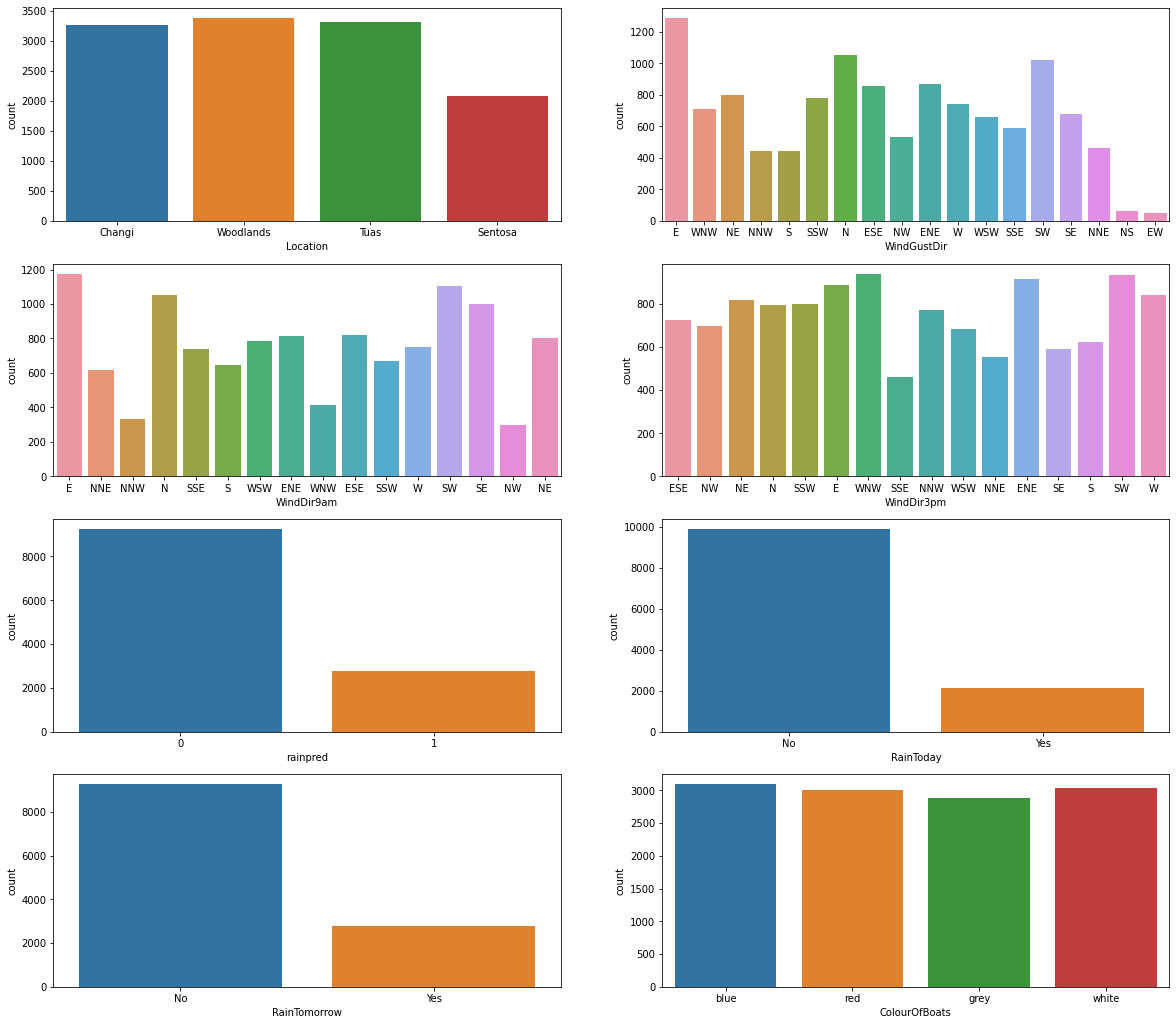

In [20]:
fig, axarr  = plt.subplots(4,2, figsize=(20, 18))
sns.countplot(x='Location', data=df, ax=axarr[0,0])
sns.countplot(x='WindGustDir', data=df, ax=axarr[0,1])
sns.countplot(x='WindDir9am', data=df, ax=axarr[1,0])
sns.countplot(x='WindDir3pm', data=df, ax=axarr[1,1])
sns.countplot(x='rainpred', data=df, ax=axarr[2,0])
sns.countplot(x='RainToday', data=df, ax=axarr[2,1])
sns.countplot(x='RainTomorrow', data=df, ax=axarr[3,0])
sns.countplot(x='ColourOfBoats', data=df, ax=axarr[3,1])
plt.show()

Observations:

"WindGustDir", "WindDir9am", "WindDir3pm" has multiple classes (>4)

"Location", "ColourOfBoats" has 4 classes

"RainToday" and "RainTomorrow" are binary variables

"rainpred" is the engineered binary variable derived from "Rainfall" variable (which is numerical)

##### Numerical variables

Numerical variables have dtypes that are of float or integer dtype. 2 types of data analysis can be performed:

- Assess for presence of Outliers

- Perform Spearman correlation to evaluate monotonic relationship between any 2 variables

As the categorical variables have not been converted to float or int dtype at this step yet, the numerical variables are to be isolated from the main dataframe. To assess for presence of outliers, boxplots shall be generated first, followed by a statistical calculation of the total percentage of outliers. Statistical outliers are defined as datapoints that lie outside the interquartile range (Q3 - Q1) within the dataset of the assessed variable.

The dataframe is first forked into 2 sub-dataframes: Categorical variables assigned to df_cat and float/integer variables assigned to df_num

In [21]:
df_cat = df.copy().select_dtypes(include=["object"])
df_num = df.copy().select_dtypes(include=["float64", "int32", "int64"])


In [22]:
df_num = df_num.drop(["Rainfall", "rainpred"], axis=1).copy()


Presence of outliers

For this exercise, outliers are calculated by determining the first and third quartile figure for each of the analysed variable. Values outside of the first and third quartile shall be treated as outliers. To assess the distribution of outliers, boxplot and individual statistical calculation  shall be performed to determine the total percentage of outliers in each variable:

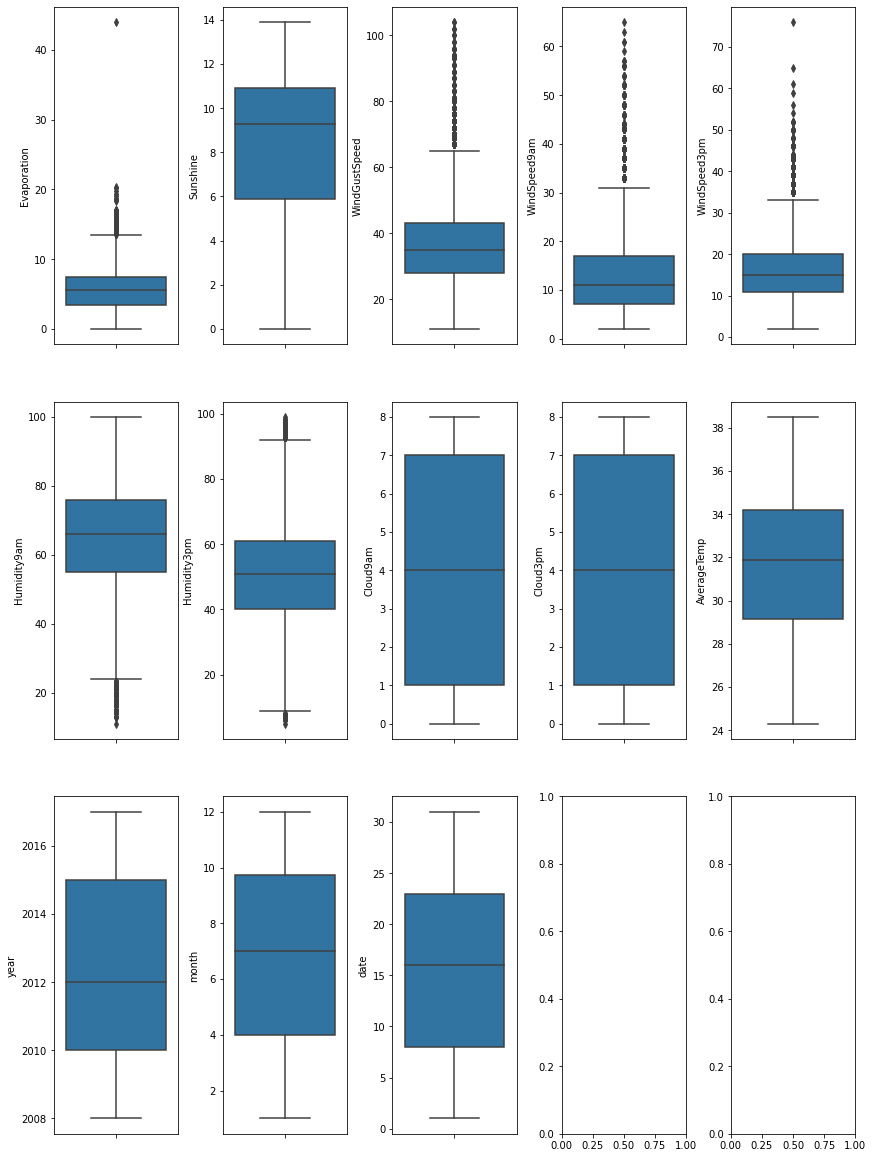

In [23]:
visual.out_vis(df_num)

In [24]:
visual.out_pc(df_num)

'Evaporation' = 295 (2.5%) outliers
'Sunshine' = 1032 (8.6%) outliers
'WindGustSpeed' = 657 (5.5%) outliers
'WindSpeed9am' = 674 (5.6%) outliers
'WindSpeed3pm' = 807 (6.7%) outliers
'Humidity9am' = 481 (4.0%) outliers
'Humidity3pm' = 919 (7.6%) outliers
'Cloud9am' = 0 (0.0%) outliers
'Cloud3pm' = 0 (0.0%) outliers
'AverageTemp' = 0 (0.0%) outliers
'year' = 0 (0.0%) outliers
'month' = 0 (0.0%) outliers
'date' = 0 (0.0%) outliers


Observations:

Low stdev observed in "Evaporation", but there is one obvious outlier
Moderate stdev observed in "WindSpeed9am", "WindSpeed3pm"
High stdev observed in "WindGustSpeed", "Humidity9am", "Humidity3pm"

Running the for loop across the numerical variables show that outliers form less than 10% of sample size.

Although outliers reflected for this dataset does not necessarily mean invalid data input as extreme/unusual weather conditions do periodically occur, they can invariably skew the dataset and produce biasness in the variable, and in turn compromise the predictive value of the variable. To reduce skewing, it would be preferable for outliers to be removed.

##### Spearman correlation

Spearman correlation evaluates the monotonic relationship between any two given variables. (In a monotonic relationship, the variables tend to change together, but not necessarily at a constant rate.) The Spearman correlation coefficient is based on the ranked values for each variable rather than the raw data. The purpose of this analysis is to assess any significant interdependent relationship  between two variables. Target variable, "rainpred" has been dropped from the numerical dataframe.


The numeric 10 most correlated pairs, Spearman method:


,X,Y,r
0,WindGustSpeed,WindSpeed3pm,0.708152
1,Cloud9am,Cloud3pm,0.677392
2,WindGustSpeed,WindSpeed9am,0.670140
3,Humidity9am,Humidity3pm,0.633090
4,Evaporation,AverageTemp,0.570844
5,Evaporation,Humidity9am,-0.498233
6,Sunshine,Humidity9am,-0.551952
7,Sunshine,Humidity3pm,-0.584583
8,Sunshine,Cloud9am,-0.680768
9,Sunshine,Cloud3pm,-0.724005


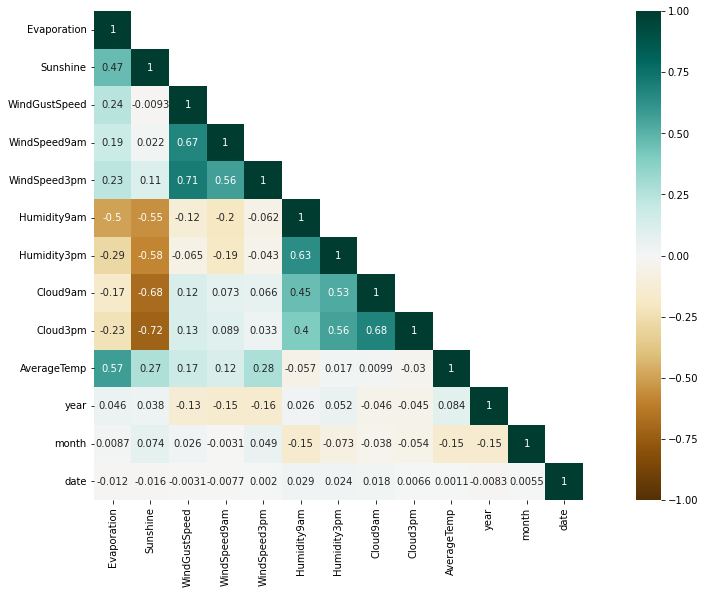

In [25]:
visual.corr(df_num)

Top 5 paired variables showing positive interdependent and negative interdependent relationship are shown below, with "r" score reflected above.

Extent of interdependence between 2 paired variables reflects how one variable influences the other, and consequently whether it has any significant influence on the predictive value vis-a-vis the target variable ("rainpred").

### Additional data preprocessing

Post-EDA, dataframe needs to be processed further before train test split and machine learning models can be applied. Key steps for additional preprocessing are namely:

1. Removing outliers out of interquartile range
2. Reconstituting the numerical dataframe and categorical dataframe back to unified dataframe by applying inner join twice
3. Map binary variables "RainToday" and "RainTomorrow" to 0 and 1 from No and Yes
4. Applying one-hot encoding to categorical variables
5. Dropping the processed variables

At different intervals of pre-processing, dataframe and df.info shall be printed out to verify that the dataframe has been processed correctly.

Apply to drop outliers:

In [26]:
Q1 = df_num.quantile(0.25)
Q3 = df_num.quantile(0.75)
IQR = Q3 - Q1

In [27]:
df_num = df_num[~((df_num < (Q1 - 1.5 * IQR)) |(df_num > (Q3 + 1.5 * IQR))).any(axis=1)]
df_num.shape

(11191, 13)

Perform first inner join to re-merge retained rows in df_num with df_cat (11191 rows in total). Dropped rows in df_num are excluded in df_new.

In [28]:
df_new = df_num.join(df_cat, how='inner')

In [29]:
df_new 

,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Cloud9am,Cloud3pm,AverageTemp,...,Date,Location,WindGustDir,WindDir9am,WindDir3pm,Pressure9am,Pressure3pm,RainToday,RainTomorrow,ColourOfBoats
0,7.0,11.2,35.0,15.0,19.0,60.0,54.0,4.0,5.0,33.4,...,2009-03-08,Changi,E,E,ESE,med,med,No,No,blue
1,8.4,9.6,37.0,13.0,28.0,60.0,56.0,1.0,2.0,35.4,...,2014-11-12,Woodlands,WNW,NNE,NW,med,low,No,Yes,blue
3,7.2,11.4,31.0,9.0,13.0,51.0,53.0,1.0,1.0,31.4,...,2015-10-12,Changi,NE,NNW,NE,high,med,No,No,red
4,7.0,8.5,33.0,13.0,19.0,68.0,64.0,6.0,5.0,35.4,...,2013-10-27,Woodlands,NNW,N,N,med,med,No,No,grey
5,10.6,12.8,43.0,15.0,22.0,54.0,45.0,1.0,0.0,31.9,...,2014-02-08,Tuas,S,SSE,SSW,med,med,No,No,grey
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12990,4.0,10.9,39.0,13.0,17.0,65.0,47.0,3.0,2.0,29.4,...,2014-09-26,Tuas,NNW,NNE,WNW,med,med,No,Yes,blue
12991,4.4,1.9,37.0,6.0,17.0,89.0,51.0,8.0,7.0,29.2,...,2011-08-21,Changi,SE,SSW,SE,high,high,Yes,Yes,red
12993,7.4,0.6,35.0,4.0,9.0,57.0,48.0,7.0,8.0,31.3,...,2016-09-29,Changi,NNW,N,NNW,low,low,No,Yes,white
12995,4.4,12.0,31.0,13.0,9.0,68.0,52.0,5.0,1.0,30.5,...,2011-02-14,Sentosa,S,SSE,SSE,high,high,Yes,No,blue


Perform second inner join to re-join "rainpred" column, which has been temporarily dropped earlier to identify outliers using IQR.

"rainpred" is the target variable that is used for this problem statement.

In [30]:
df_new = df_new.join(df["rainpred"], how ='inner')
df_new 

,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Cloud9am,Cloud3pm,AverageTemp,...,Location,WindGustDir,WindDir9am,WindDir3pm,Pressure9am,Pressure3pm,RainToday,RainTomorrow,ColourOfBoats,rainpred
0,7.0,11.2,35.0,15.0,19.0,60.0,54.0,4.0,5.0,33.4,...,Changi,E,E,ESE,med,med,No,No,blue,0
1,8.4,9.6,37.0,13.0,28.0,60.0,56.0,1.0,2.0,35.4,...,Woodlands,WNW,NNE,NW,med,low,No,Yes,blue,0
3,7.2,11.4,31.0,9.0,13.0,51.0,53.0,1.0,1.0,31.4,...,Changi,NE,NNW,NE,high,med,No,No,red,0
4,7.0,8.5,33.0,13.0,19.0,68.0,64.0,6.0,5.0,35.4,...,Woodlands,NNW,N,N,med,med,No,No,grey,1
5,10.6,12.8,43.0,15.0,22.0,54.0,45.0,1.0,0.0,31.9,...,Tuas,S,SSE,SSW,med,med,No,No,grey,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12990,4.0,10.9,39.0,13.0,17.0,65.0,47.0,3.0,2.0,29.4,...,Tuas,NNW,NNE,WNW,med,med,No,Yes,blue,0
12991,4.4,1.9,37.0,6.0,17.0,89.0,51.0,8.0,7.0,29.2,...,Changi,SE,SSW,SE,high,high,Yes,Yes,red,1
12993,7.4,0.6,35.0,4.0,9.0,57.0,48.0,7.0,8.0,31.3,...,Changi,NNW,N,NNW,low,low,No,Yes,white,0
12995,4.4,12.0,31.0,13.0,9.0,68.0,52.0,5.0,1.0,30.5,...,Sentosa,S,SSE,SSE,high,high,Yes,No,blue,1


Map binary variables "RainToday" and "RainTomorrow" to 0 and 1 from No and Yes:

In [31]:
posteda_clean.objmap(df_new)

For the below function, one-hot encoding is applied to multi-class categorical variables, and re-concatenating them after performing one-hot encoding. For the expanded categories, the prefix of the initial class is retained, and the name of each attribute is appended onto the class. For instance, to classify datapoints whereby WindGustDir is blowing to the north, the newly encoded attribure is renamed as "WindGustDir_N". dtype for the expanded dataframes has been set to int, so that output returns 0 for False and 1 for True.

As a second step, columns that have been processed either into deriative columns, or splitted via one-hot encoding are dropped.

Finally, the modified dataframe is written to a pickle file using pd.to_pickle function. On this ipynb, pd.read_pickle is applied so that ipynb can correctly apply the transformations:

In [32]:
posteda_clean.onehotencode_drop(df_new)

In [33]:
df_new = pd.read_pickle('df_new.pkl')

In [34]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11191 entries, 0 to 12996
Data columns (total 70 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Evaporation         11191 non-null  float64
 1   Sunshine            11191 non-null  float64
 2   WindGustSpeed       11191 non-null  float64
 3   WindSpeed9am        11191 non-null  float64
 4   WindSpeed3pm        11191 non-null  float64
 5   Humidity9am         11191 non-null  float64
 6   Humidity3pm         11191 non-null  float64
 7   Cloud9am            11191 non-null  float64
 8   Cloud3pm            11191 non-null  float64
 9   AverageTemp         11191 non-null  float64
 10  year                11191 non-null  int32  
 11  month               11191 non-null  int32  
 12  date                11191 non-null  int32  
 13  RainToday           11191 non-null  int64  
 14  RainTomorrow        11191 non-null  int64  
 15  rainpred            11191 non-null  int64  
 16  Location_

In [35]:
df_new.shape

(11191, 70)

Observation:

The unified dataframe prints out the correct number of rows and columns. Note that all dtypes have been converted to float or integer, otherwise minmaxscaling cannot be performed if there are any dtypes that remain as object.

Upon applying one-hot encoding, multiple sub-dataframes are generated, and they are re-constituted back to the main dataframe using concatenation. pd.to_pickle is applied so that the transformations to the new dataframe is saved. On the ipynb, pd.read_pickle is applied so that the ipython environment can read the transformations applied to the dataframe.

For the multi-class categorical variables, several variables have 4 or more classes, in particular the variables WindGustSpeed, WindDir9am, WindDir3pm which have 18 classes each, and applying one-hot encoding to these classes greatly increases the total number of columns. 


##### Under/oversampling

The independent variable and dependent variables need to be seperated. The dependent variable, also known as the target variable is the attribute to be investigated, which is "rainpred". The independent variable consist of all other variables whose relationship are regressed against the depeendent variable.

1. Identify independent variable as X; drop "rainpred" from the main dataframe
2. Identify dependent variable as y; assign y to "rainpred"

In [36]:
X = df_new.drop('rainpred', axis = 1)
y = df_new['rainpred']

Doing a value_count show that there are some 2470 entries that are positive (rainfall >1.0mm) and some 8710 entries that are negative (rainfall <= 1.0mm). To correct the class imbalance, oversampling of the lesser class shall be performed first, followed by undersampling of the larger class.

In [37]:
y.value_counts()

rainpred
0    8714
1    2477
Name: count, dtype: int64

In [38]:
over = SMOTE(sampling_strategy=0.65)
X, y = over.fit_resample(X, y)

In [39]:
y.value_counts()

rainpred
0    8714
1    5664
Name: count, dtype: int64

In [40]:
under = RandomUnderSampler(sampling_strategy=1.0)
X, y = under.fit_resample(X, y)

In [41]:
y.value_counts()

rainpred
0    5664
1    5664
Name: count, dtype: int64

After oversampling/undersampling has been applied, both negative and positive classes have now become balanced.

### Train-test split

After issue of class imbalance has been resolved, apply train-test split to the dataset, with a ratio of 60% train, 20% validation and 20% test. Then perform min-max scaling and fit transform. Min max scaling is needed to reduce variance which may affect predictive performance to the dataset.

In [42]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state= 111)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, stratify = y_temp, test_size = 0.2, random_state= 111)

print_tts.tts(X_train, X_val, X_test, y_train, y_val, y_test)

Shape of the X1_train (7249, 69)
Shape of the X1_val (1813, 69)
Shape of the X1_test (2266, 69)
Shape of the y1_train (7249,)
Shape of the y1_val (1813,)
Shape of the y1_test (2266,)


In [43]:
scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns)

X_val = pd.DataFrame(scaler.fit_transform(X_val), columns = X.columns)

X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X.columns)

X_val.head(10)

,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Cloud9am,Cloud3pm,AverageTemp,...,WindGustDir_NS,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW
0,0.388060,0.686131,0.173077,0.137931,0.290323,0.560000,0.493827,0.125000,0.375000,0.697479,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.373134,0.591241,0.788462,0.896552,0.709677,0.213333,0.395062,0.375000,0.375000,0.369748,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.686567,0.854015,0.326923,0.310345,0.354839,0.053333,0.049383,0.125000,0.125000,0.773109,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.537313,0.802920,0.326923,0.172414,0.483871,0.546667,0.518519,0.625000,0.250000,0.588235,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.249852,0.685918,0.423077,0.517241,0.492256,0.731600,0.609261,0.668766,0.548740,0.596148,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.402985,0.138686,0.596154,0.241379,0.483871,0.893333,0.740741,0.875000,1.000000,0.378151,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,0.179104,0.620438,0.923077,0.517241,0.483871,0.533333,0.506173,0.125000,0.375000,0.159664,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,0.208955,0.693431,0.423077,0.379310,0.580645,0.826667,0.617284,0.750000,0.875000,0.848739,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.283582,0.671533,0.461538,0.000000,0.483871,0.720000,0.419753,0.250000,0.375000,0.176471,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,0.194030,0.220548,0.550426,0.469729,0.506095,0.950814,0.695198,0.971294,0.817589,0.273574,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Model selection

10 classifier are selected as candidate models for ML pipeline use - 5 4 tree/ensemble models, 4 linear models and 2 naive bayes models. Each model shall be assessed by the performance of its metric scores: Accuracy, Precision, Recall, F1 and ROC-AUC curve for the training, validation and test data sets. Selection of models shall be influenced by return of best score marks and consistency, though it needs to be stressed that these are not sole factors in consideration of model selection.

In [44]:
models = [make_pipeline(StandardScaler(), LogisticRegression()),
        make_pipeline(StandardScaler(), Perceptron()), 
        make_pipeline(StandardScaler(), SGDClassifier(loss='log', n_iter_no_change=100)), 
        make_pipeline(StandardScaler(), RidgeClassifierCV()), 
        make_pipeline(StandardScaler(), GaussianNB()), 
        make_pipeline(StandardScaler(), BernoulliNB()),
        make_pipeline(StandardScaler(), DecisionTreeClassifier()),
        make_pipeline(StandardScaler(), AdaBoostClassifier(n_estimators = 100)),
        make_pipeline(StandardScaler(), GradientBoostingClassifier(n_estimators = 100)),  
        make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators = 100)), 
        make_pipeline(StandardScaler(), BaggingClassifier(n_estimators = 100))]

model_names = ['Logistic Regression', 'Perceptron', 'Stochastic Gradient Descent', 'Ridge Classifier', \
        'GaussianNB', 'BernoulliNB', 'Decision Tree Classifier', \
        'AdaBoostClassifier', 'GradientBoostingClassifier', 'RandomForestClassifier', 'BaggingClassifier']

Train set

In [45]:
accuracy_train = []
precision_train = []
recall_train = []
f1_train = []
roc_auc_train = []

In [46]:
for model in range(len(models)):
    clf = models[model]
    clf.fit(X_train, y_train)
    pred_train = clf.predict(X_train)
    accuracy_train.append(accuracy_score(pred_train, y_train))
    precision_train.append(precision_score(pred_train, y_train))
    recall_train.append(recall_score(pred_train, y_train))
    f1_train.append(f1_score(pred_train, y_train))
    roc_auc_train.append(roc_auc_score(pred_train, y_train))

c:\Users\Han\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


In [47]:
df_stat_train = pd.DataFrame({'Algorithm' : model_names, 
                        'Accuracy' : accuracy_train, 
                        'Precision': precision_train, 
                        'Recall': recall_train, 
                        'F1' : f1_train, 
                        'ROC AUC': roc_auc_train})

df_stat_train

,Algorithm,Accuracy,Precision,Recall,F1,ROC AUC
0,Logistic Regression,0.940268,0.914759,0.963953,0.938712,0.941415
1,Perceptron,0.914057,0.900414,0.925695,0.912879,0.914365
2,Stochastic Gradient Descent,0.940819,0.911172,0.968622,0.939019,0.942373
3,Ridge Classifier,0.931301,0.870345,0.991203,0.926851,0.937805
4,GaussianNB,0.910195,0.866483,0.949516,0.906101,0.913352
5,BernoulliNB,0.860670,0.893241,0.838643,0.865081,0.862208
6,Decision Tree Classifier,1.000000,1.000000,1.000000,1.000000,1.000000
7,AdaBoostClassifier,0.944958,0.926897,0.961649,0.943953,0.945538
8,GradientBoostingClassifier,0.943165,0.912552,0.972083,0.941377,0.944830
9,RandomForestClassifier,1.000000,1.000000,1.000000,1.000000,1.000000


Validation set

In [48]:
accuracy_val = []
precision_val = []
recall_val = []
f1_val = []
roc_auc_val = []

In [49]:
for model in range(len(models)):
    clf = models[model]
    clf.fit(X_train, y_train)
    pred_val = clf.predict(X_val)
    accuracy_val.append(accuracy_score(pred_val, y_val))
    precision_val.append(precision_score(pred_val, y_val))
    recall_val.append(recall_score(pred_val, y_val))
    f1_val.append(f1_score(pred_val, y_val))
    roc_auc_val.append(roc_auc_score(pred_val, y_val))

c:\Users\Han\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


In [50]:
df_stat_val = pd.DataFrame({'Algorithm' : model_names, 
                        'Accuracy' : accuracy_val, 
                        'Precision': precision_val, 
                        'Recall': recall_val, 
                        'F1' : f1_val, 
                        'ROC AUC': roc_auc_val})

df_stat_val

,Algorithm,Accuracy,Precision,Recall,F1,ROC AUC
0,Logistic Regression,0.936569,0.916115,0.955121,0.935211,0.937306
1,Perceptron,0.912852,0.903974,0.920225,0.912027,0.912983
2,Stochastic Gradient Descent,0.938776,0.916115,0.959538,0.937324,0.939684
3,Ridge Classifier,0.937121,0.886313,0.986486,0.933721,0.941692
4,GaussianNB,0.908439,0.868653,0.943645,0.904598,0.911046
5,BernoulliNB,0.865968,0.899558,0.842813,0.870262,0.867624
6,Decision Tree Classifier,0.884721,0.901766,0.871932,0.886598,0.885167
7,AdaBoostClassifier,0.940430,0.908389,0.970519,0.938426,0.942254
8,GradientBoostingClassifier,0.917816,0.870861,0.961023,0.913723,0.921540
9,RandomForestClassifier,0.933811,0.900662,0.964539,0.931507,0.935734


Test set

In [51]:
accuracy_test = []
precision_test = []
recall_test = []
f1_test = []
roc_auc_test = []

In [52]:
for model in range(len(models)):
    clf = models[model]
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    accuracy_test.append(accuracy_score(pred, y_test))
    precision_test.append(precision_score(pred, y_test))
    recall_test.append(recall_score(pred, y_test))
    f1_test.append(f1_score(pred, y_test))
    roc_auc_test.append(roc_auc_score(pred, y_test))

c:\Users\Han\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


In [53]:
df_stat_test = pd.DataFrame({'Algorithm' : model_names, 
                        'Accuracy' : accuracy_test, 
                        'Precision': precision_test, 
                        'Recall': recall_test, 
                        'F1' : f1_test, 
                        'ROC AUC': roc_auc_test})

df_stat_test

,Algorithm,Accuracy,Precision,Recall,F1,ROC AUC
0,Logistic Regression,0.932039,0.900265,0.961357,0.929809,0.933791
1,Perceptron,0.908650,0.889673,0.924771,0.906883,0.909239
2,Stochastic Gradient Descent,0.931598,0.897617,0.963068,0.929191,0.933600
3,Ridge Classifier,0.924978,0.858782,0.989827,0.919660,0.932560
4,GaussianNB,0.904678,0.853486,0.950836,0.899535,0.908965
5,BernoulliNB,0.847308,0.868491,0.833192,0.850475,0.847933
6,Decision Tree Classifier,0.893645,0.884378,0.901079,0.892650,0.893780
7,AdaBoostClassifier,0.918800,0.873786,0.960233,0.914972,0.922222
8,GradientBoostingClassifier,0.904678,0.845543,0.958959,0.898687,0.910419
9,RandomForestClassifier,0.932921,0.888791,0.974831,0.929825,0.936320


Observations:

The models listed above are derived from sklearn library and are supervised learning models. From the comparison of models shown above, DecisionTreeClassifier, RandomForestClassifier and BaggingClassifier return the highest metric scores of 1.00 in the training dataset, but this is reduced to 0.80-0.90 in the validation and test datasets, indicating overfitting during training and not suitable for machine learning. 

All 3 models mentioned are either tree or ensemble models. Adaboostclassifier and Gradientboostingclarrifier shows consistency between the train, validation and test datasets and have very similar metric results. However, it must be noted that Gradientboostingclarrifier require considerably more computational power as compared to Adaboostclassifier especially when Cross Validation is performed.

For the linear models, Ridge Classifier shows perfect Recall score of 1.00 in the train, validation and test datasets but this is offset by much lower Precision scores of 0.75. In contrast, Perceptron has higher Precision scores than Recall, while having the lowest F1 and ROC AUC scores among the 4 linear classifiers. Logistic Regression and Stochastic Gradient Descent have more balanced Precision to Recall scores relative to Ridge Classifier and also good F1 and ROC AUC scores.

For the choice of 3 machine learning models, 2 supervised learning models and 1 unsupervised learning model shall be applied. The unsupervised learning model shall be k-nearest neighbour (kNN), while the supervised learning metod, Logistic Regression and Gradient Boosting Classifier shall be attempted.

### Logistic regression

Perform logistic regression to the dataset. Logistic regression is a linear model which calculates the weighted sum of each variable, with 0 as the minimun and 1 as the maximum coefficient. The variable with the highest coefficient is deemed to be the most significant.

Accuracy: 0.9338040600176523
Precision: 0.9649952696310312
Recall: 0.9002647837599294
F1: 0.9315068493150684
ROC AUC: 0.9338040600176523
__________________________________


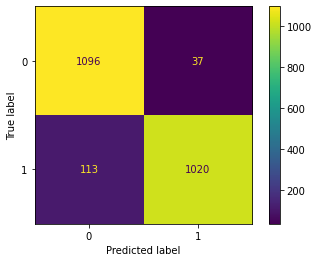

In [54]:
lr = LogisticRegression()

# feed training data to the model
lr.fit(X_train, y_train)

# predicting the test set results
predlr = lr.predict(X_test)

metricplot.evaluate(y_test, predlr)

# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test)
plt.grid(False)
plt.show()

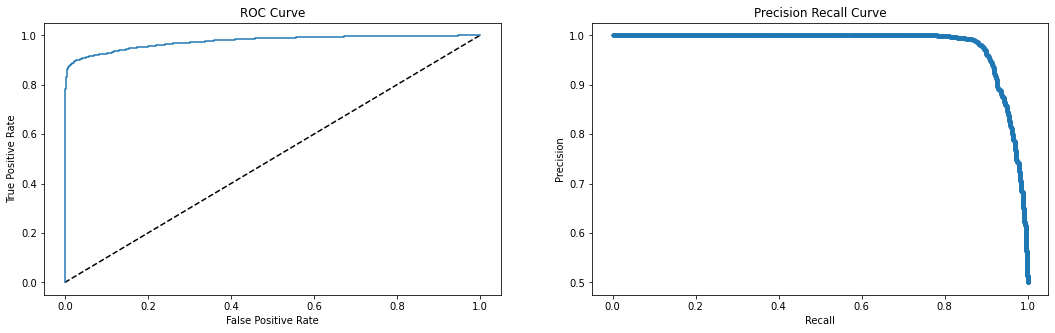

In [55]:
dataplot.curves(X_test, y_test, lr)

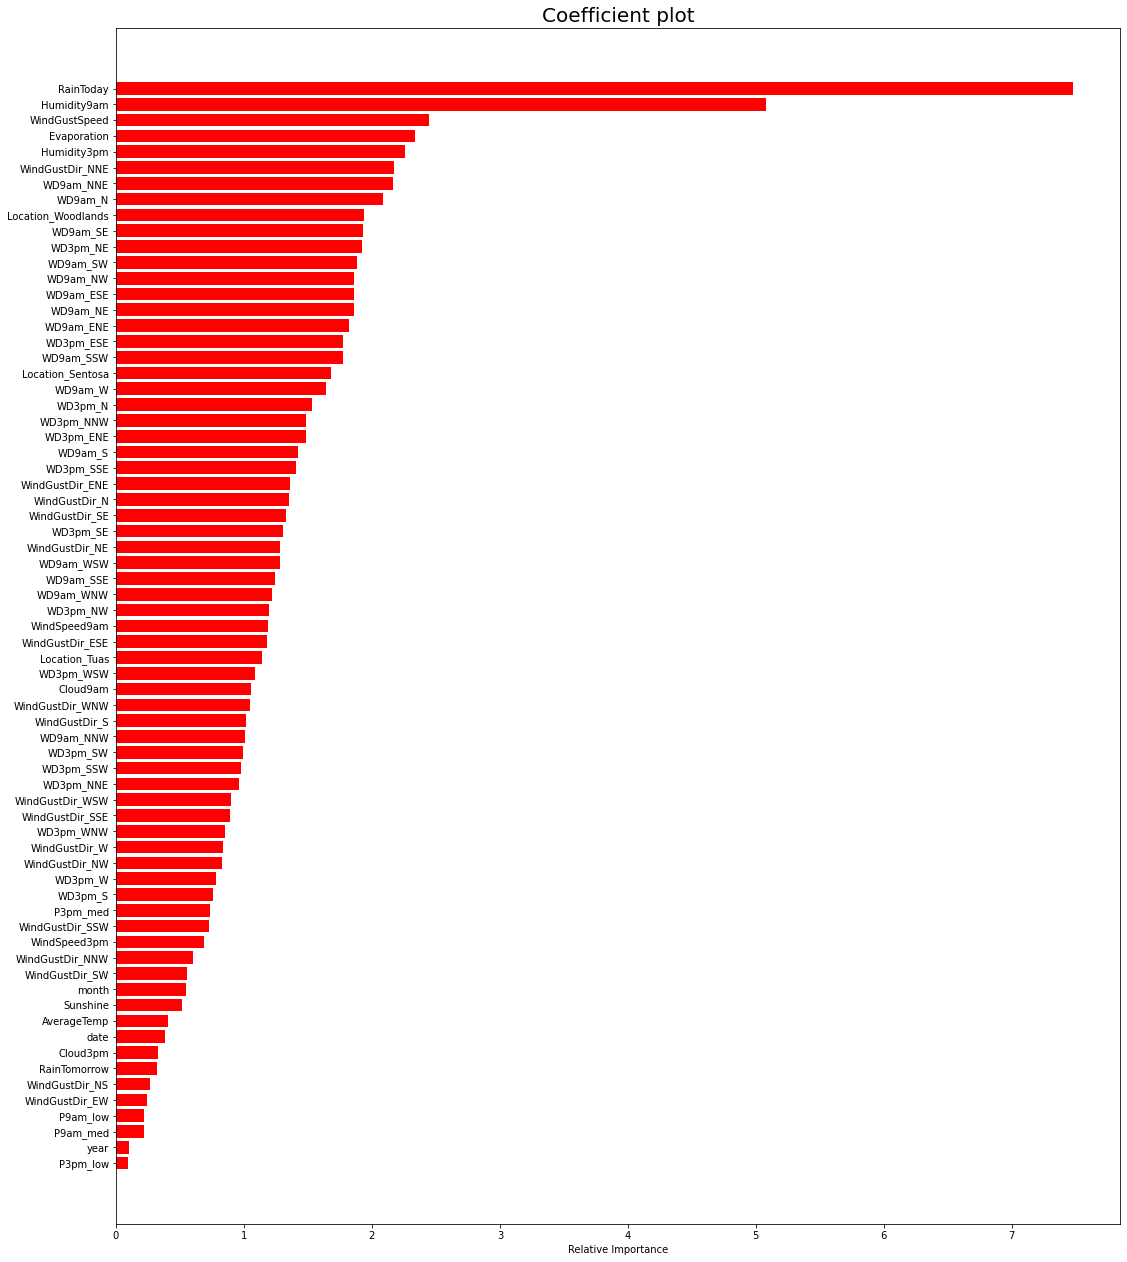

In [56]:
dataplot.coefplot(X_test, lr)

Observations:

Most significant variable returned is RainToday, followed by Humidity9am in second place and Evaporation, WindGustSpeed and WindGustDir_NNE in 3-5th places neck-to-neck. 

Using RainToday as a predictive variable to determine if it will rain tomorrow does not make much sense. To make confirmatory analysis of the model's findings, rerun the model by applying Recursive Feature Elimination with Cross Validation (RFECV). In RFECV, features deemed less significant are dropped, and the optimal number of features is determined at the point where cv score is at its maximum, just before the drop point. k is the number of folds (usually set at 5 or 10), meaning the number of groups that datafrane is to be split into.

#### Logistic Regression with RFECV

In [57]:
rfecv_lr = RFECV(estimator=lr, cv=StratifiedKFold(5, random_state=42, shuffle=True), scoring="accuracy")
rfecv_lr.fit(X, y)

c:\Users\Han\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Han\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

RFECV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
      estimator=LogisticRegression(), scoring='accuracy')

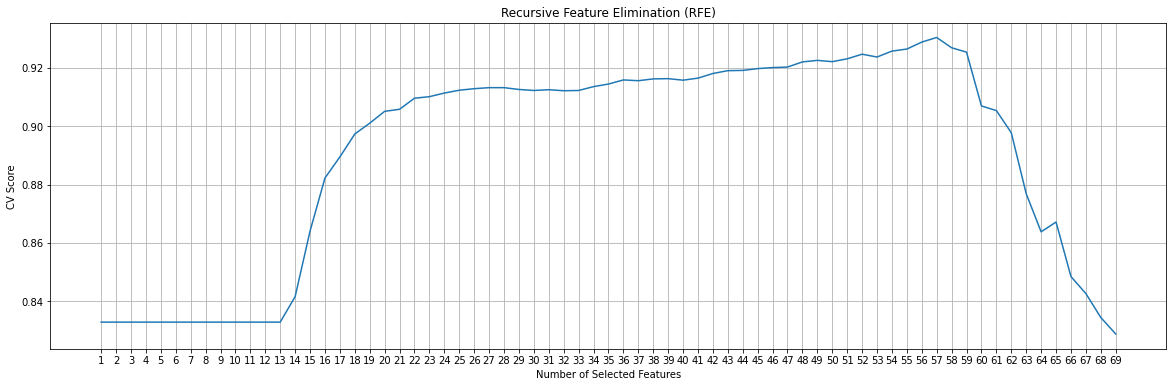

The optimal number of features: 57


In [58]:
plt.figure(figsize=(20, 6))
plt.plot(range(1, len(rfecv_lr.cv_results_['mean_test_score'])+1), rfecv_lr.cv_results_['mean_test_score'])
plt.grid()
plt.xticks(range(1, X.shape[1]+1))
plt.xlabel("Number of Selected Features")
plt.ylabel("CV Score")
plt.title("Recursive Feature Elimination (RFE)")
plt.show()

print("The optimal number of features: {}".format(rfecv_lr.n_features_))

In [59]:
X_rfe = X.iloc[:, rfecv_lr.support_]

X_train, X_test, X_rfe_train, X_rfe_test, y_train, y_test = train_test_split(X, X_rfe, y, 
                                                                             train_size=0.8, 
                                                                             stratify=y,
                                                                             random_state=111)

print_tts.tts_rfe(X_train, X_test, X_rfe_train, X_rfe_test, y_train, y_test)


Train size: 9062
Test size: 2266
Train size RFE: 9062
Test size RFE: 2266
Train size: 9062
Test size: 2266


Accuracy: 0.9148278905560459
Precision: 0.9476190476190476
Recall: 0.8781994704324801
F1: 0.9115895556573522
ROC AUC: 0.9148278905560459
__________________________________


c:\Users\Han\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


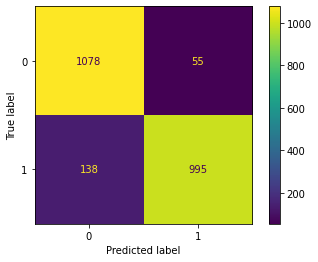

In [60]:
lr_rfe = LogisticRegression()

# feed training data to the model
lr_rfe.fit(X_rfe_train, y_train)

# predicting the test set results
predlr_rfe = lr_rfe.predict(X_rfe_test)

metricplot.evaluate(y_test, predlr_rfe)

# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(lr_rfe, X_rfe_test, y_test)
plt.grid(False)
plt.show()

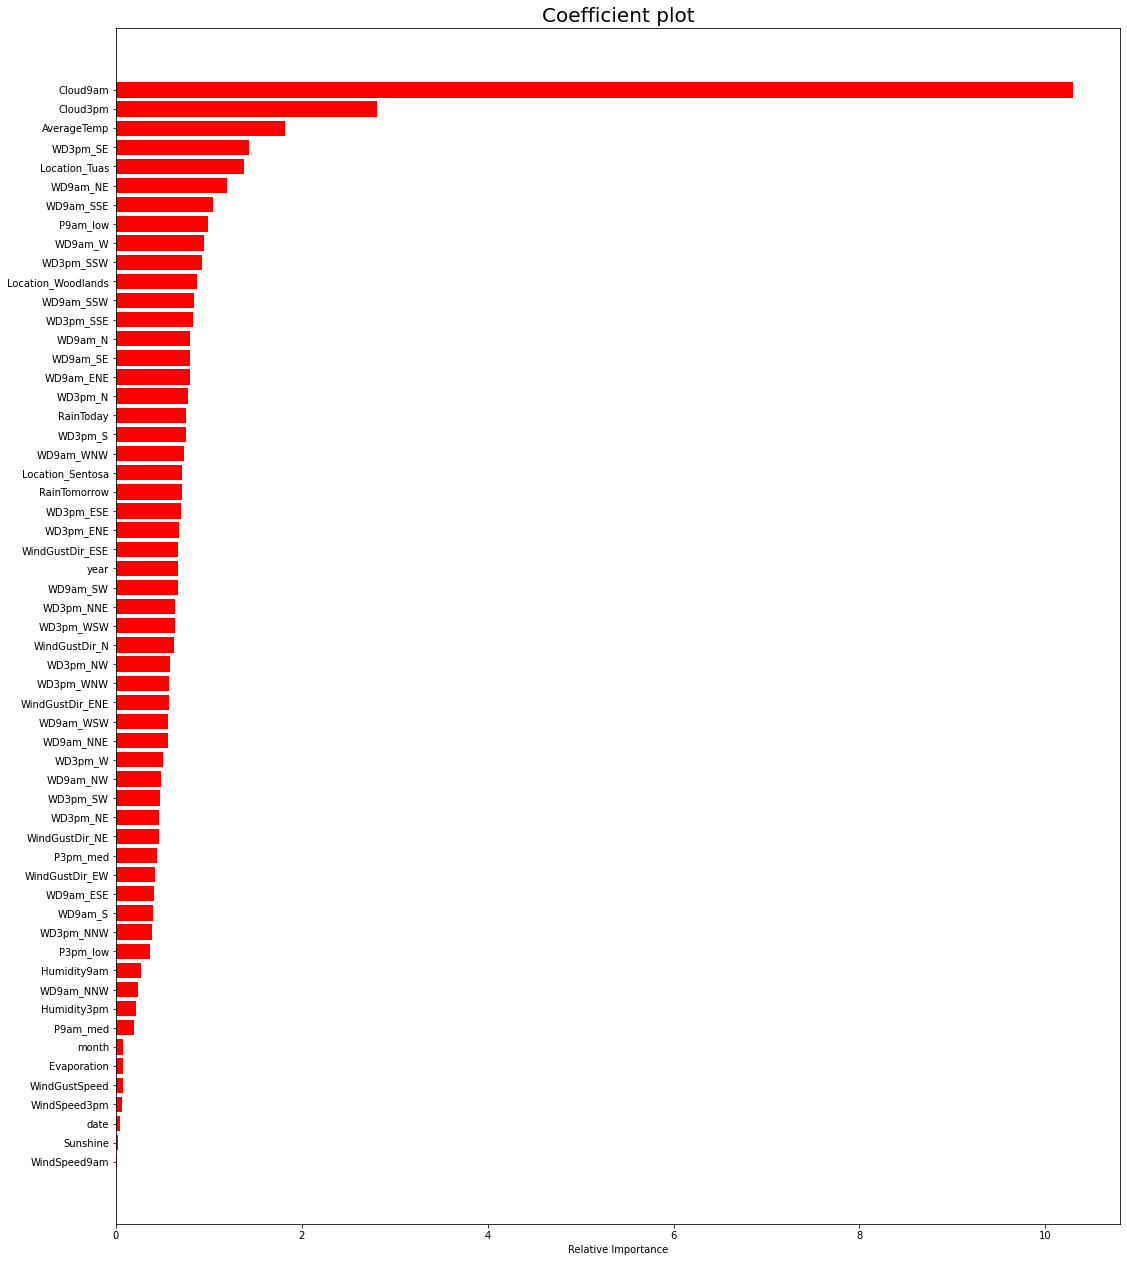

In [61]:
dataplot.coefplot(X, lr_rfe)

Observation:

Optimal number of features is shown to be at 55, although this can well change if model is re-run.

Windspeed3pm is assessed to be the most predictive variable, with WD9am_NNW, P9am_med, WD3pm_NE, WD3pm_S neck-to neck in 2nd-5th places.

### AdaBoost Classifier

Adaboost Classifier is an ensemble classifier that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset. For Cross Validation, it requires much less time than GradientBoosting Classifier, another ensemble classifier (only 8 minutes is required for 5-fold RFECV for Adaboost as compared tp 30+ minutes for 5-fold RFECV using GradientBoosting). 

Feature importance is measured using the built-in feature_importance_ attribute, which calculates the score by mean decrease in impurity. Also known as Gini importance, it calculates each feature importance as the sum over the number of splits (accross all tress) that include the feature, proportionaly to the number of samples it splits.

Accuracy: 0.9355692850838482
Precision: 0.9523373052245646
Recall: 0.9170344218887908
F1: 0.9343525179856115
ROC AUC: 0.9355692850838481
__________________________________


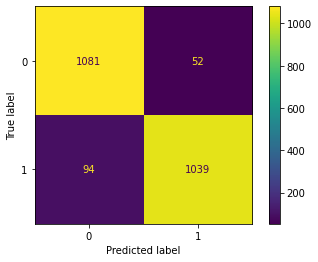

In [62]:
ABC = AdaBoostClassifier(n_estimators = 100)

# feed training data to the model
ABC.fit(X_train, y_train)

# predicting the test set results
predABC = ABC.predict(X_test)

metricplot.evaluate(y_test, predABC)

# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(ABC, X_test, y_test)
plt.grid(False)
plt.show()

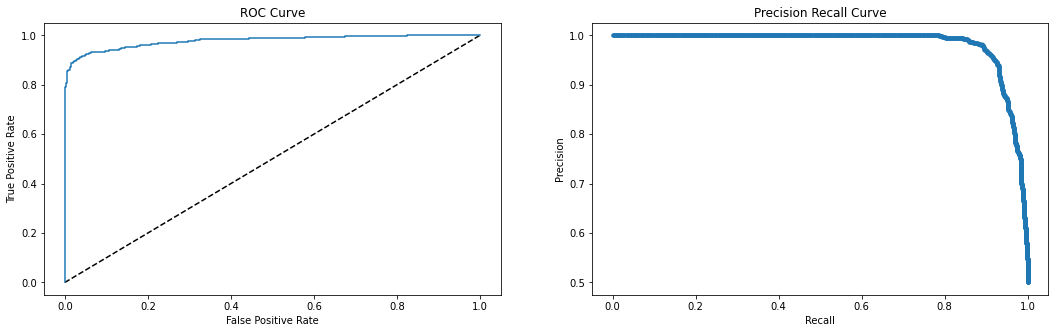

In [63]:
dataplot.curves(X_test, y_test, ABC)

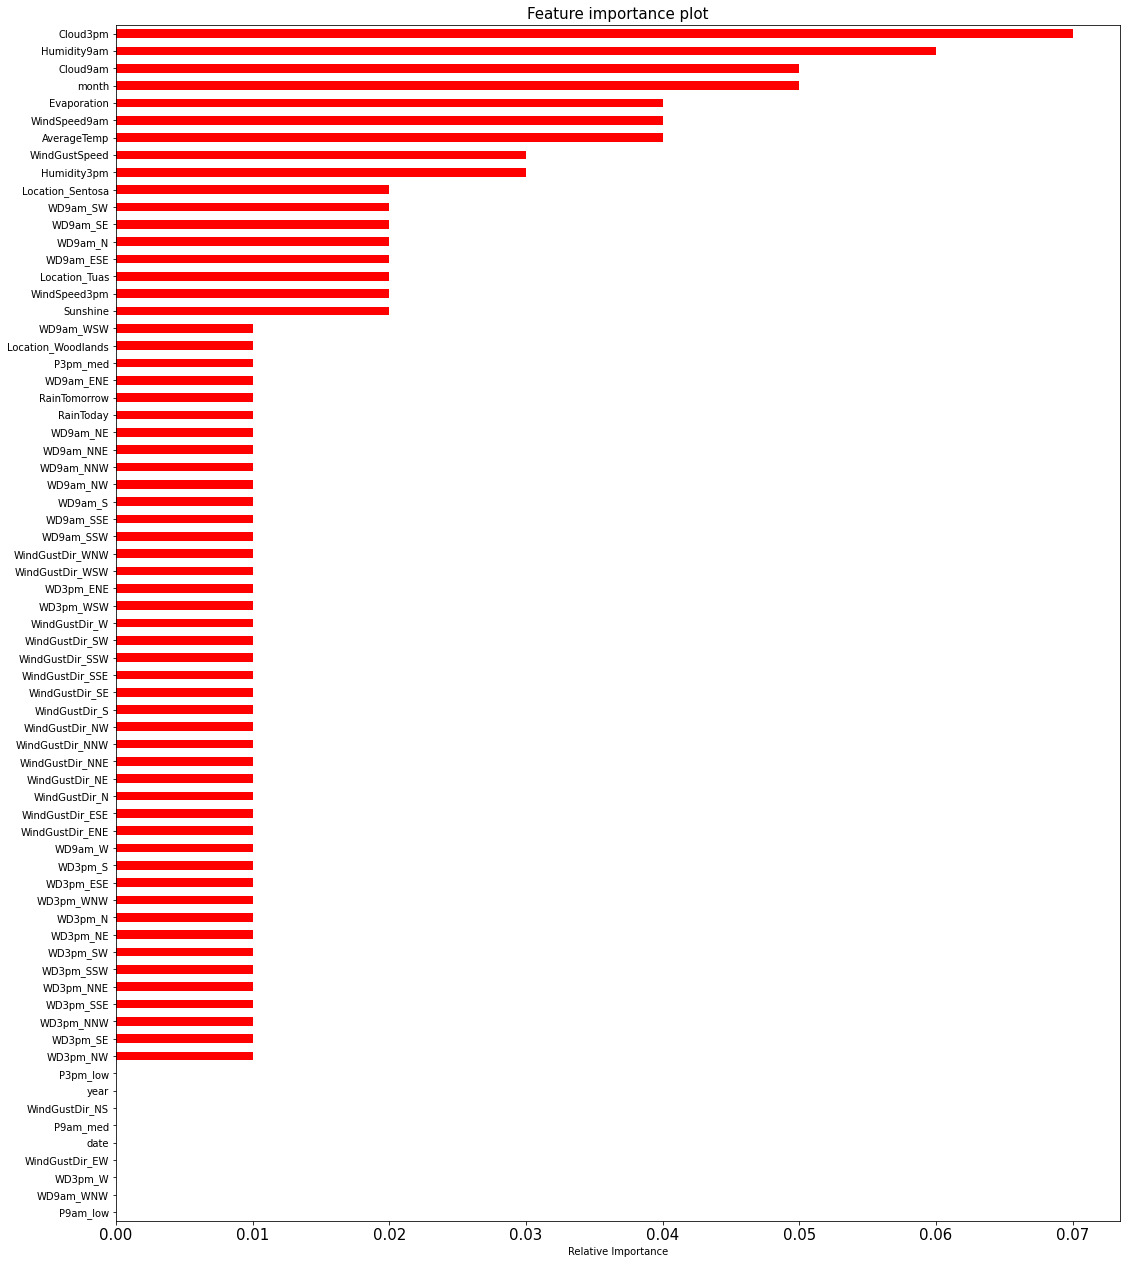

In [64]:
dataplot.feaplot(X_test, ABC)

Observations:

Humidity9am, Cloud9am, Cloud rank equally in 1st-3rd place, followed by WindGustSpeed, WindSpeed9am, AverageTemp as a second most important bloc in 4th-6th place.

#### Adaboost Classifier - RFECV

In [65]:
rfecv_ABC = RFECV(estimator=ABC, cv=StratifiedKFold(5, random_state=42, shuffle=True), scoring="accuracy")
rfecv_ABC.fit(X, y)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
      estimator=AdaBoostClassifier(n_estimators=100), scoring='accuracy')

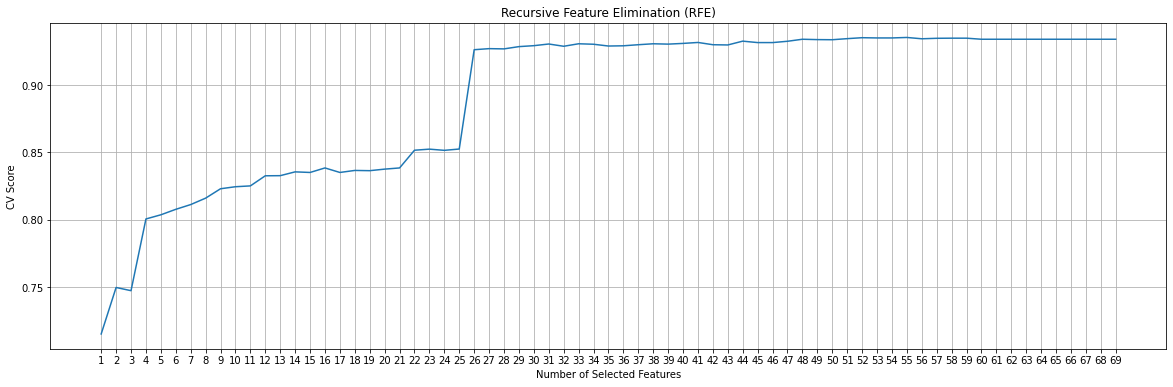

The optimal number of features: 55


In [66]:
plt.figure(figsize=(20, 6))
plt.plot(range(1, len(rfecv_ABC.cv_results_['mean_test_score'])+1), rfecv_ABC.cv_results_['mean_test_score'])
plt.grid()
plt.xticks(range(1, X.shape[1]+1))
plt.xlabel("Number of Selected Features")
plt.ylabel("CV Score")
plt.title("Recursive Feature Elimination (RFE)")
plt.show()

print("The optimal number of features: {}".format(rfecv_ABC.n_features_))

In [67]:
X_rfe = X.iloc[:, rfecv_ABC.support_]

X_train, X_test, X_rfe_train, X_rfe_test, y_train, y_test = train_test_split(X, X_rfe, y, 
                                                                             train_size=0.8, 
                                                                             stratify=y,
                                                                             random_state=111)

print_tts.tts_rfe(X_train, X_test, X_rfe_train, X_rfe_test, y_train, y_test)

Train size: 9062
Test size: 2266
Train size RFE: 9062
Test size RFE: 2266
Train size: 9062
Test size: 2266


Accuracy: 0.9223300970873787
Precision: 0.9426456984273821
Recall: 0.8993821712268314
F1: 0.920505871725384
ROC AUC: 0.9223300970873787
__________________________________


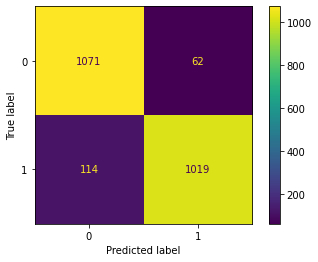

In [68]:
ABC_rfe = AdaBoostClassifier()

# feed training data to the model
ABC_rfe.fit(X_rfe_train, y_train)

# predicting the test set results
predABC_rfe = ABC_rfe.predict(X_rfe_test)

metricplot.evaluate(y_test, predABC_rfe)

# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(ABC_rfe, X_rfe_test, y_test)
plt.grid(False)
plt.show()

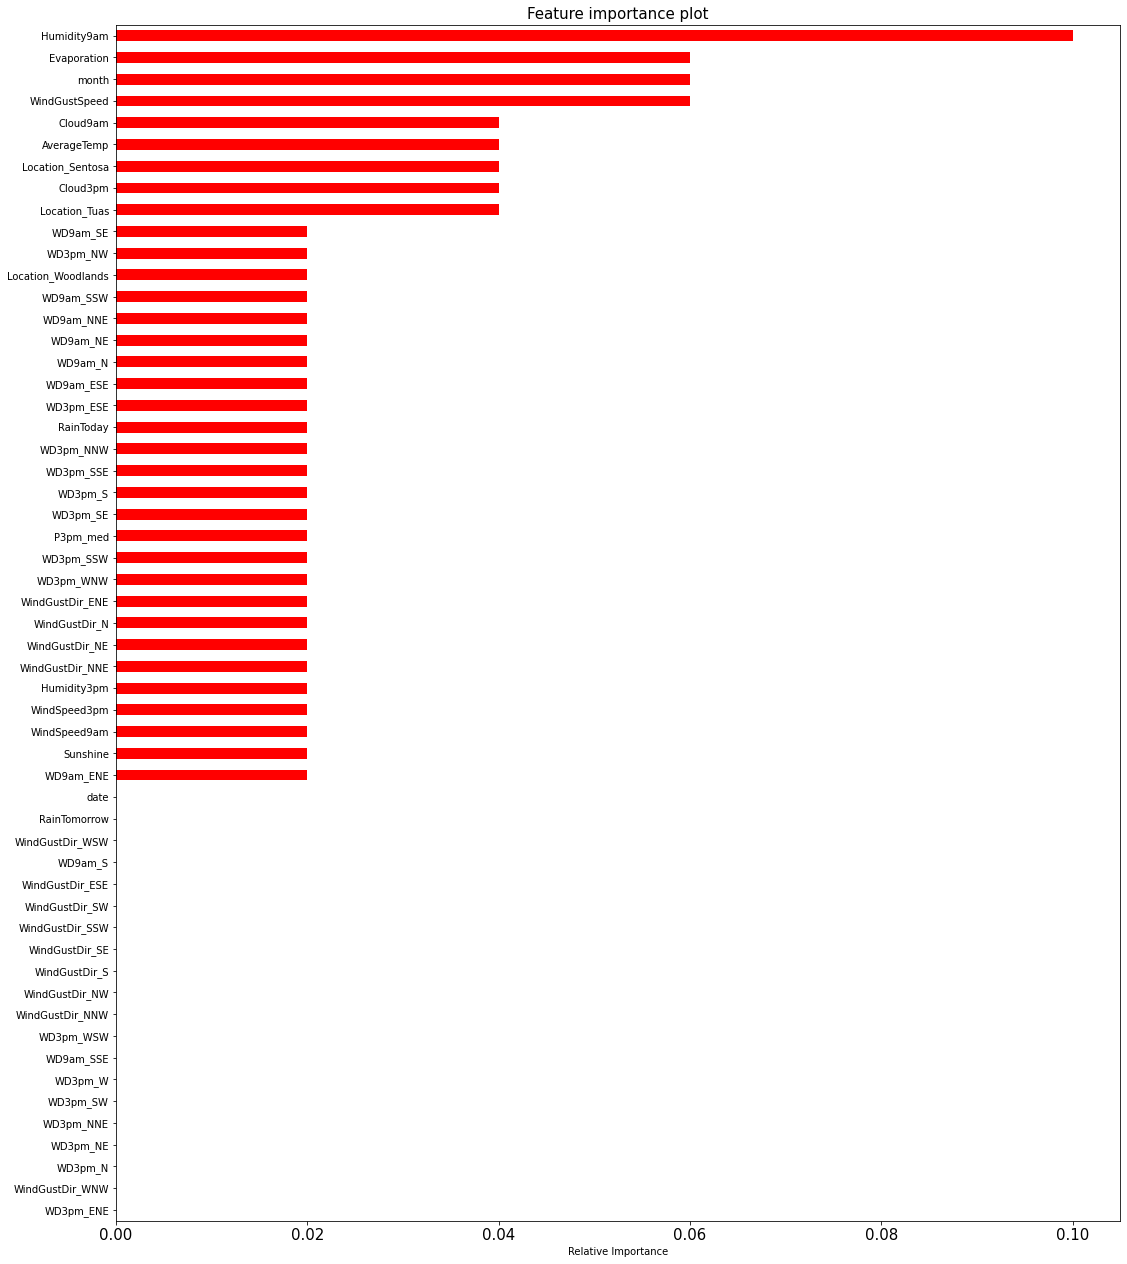

In [69]:
dataplot.feaplot(X_rfe_test, ABC_rfe)

Observation:

Optimal number of features is shown to be at 56, although this can well change if model is re-run.

Cloud9am is assessed to be the most predictive variable, followed by Humidity9am and month jointly in 2nd and 3rd places. LocationSentosa, WindGustSpeed, WindSpeed9am, LocationTuas, LocationWoodlands are jointly in 4th-8th places.

### k-nearest neighbour

Identify best k value between test and train accuracy. Best k-score based on the test/train accuracy will be used to generate performance matrix and permutation importance. kNN is an unsupervised learning method, in contrast to the linear and ensemble model methods with are supervisory in nature.

As kNN does not have attribute to feature importance, permutation importance shall be performed as a comparable alternative. It must be noted however that permutation importance does not reflect to the intrinsic predictive value of a feature by itself but how important this feature is for a particular model.

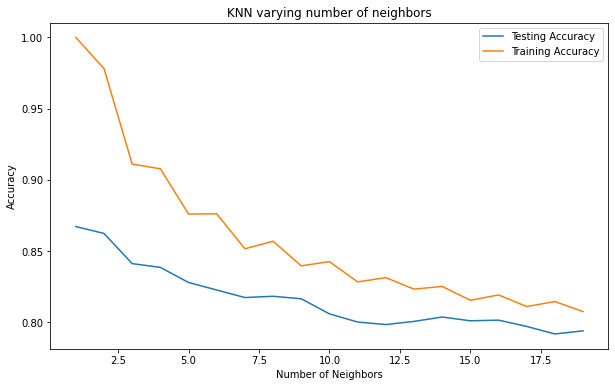

In [72]:
visual.neighclass(X_train, X_test, y_train, y_test)

Training and test accuracy converges significantly after n_neighbors = 4, and optimal number of n_neighbors is at around 8.

Accuracy: 0.8181818181818182
Precision: 0.7933279088689992
Recall: 0.8605472197705207
F1: 0.8255715495342929
ROC AUC: 0.8181818181818181
__________________________________


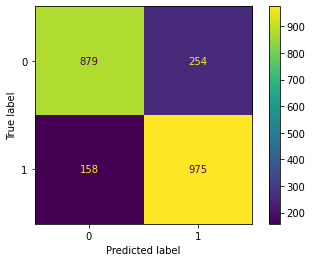

In [73]:
kNN = KNeighborsClassifier(n_neighbors=8)

#feed training data to the model
kNN.fit(X_train, y_train)

#predicting the test set results
y_pred_KNN = kNN.predict(X_test)

metricplot.evaluate(y_test, y_pred_KNN)

# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(kNN, X_test, y_test)
plt.grid(False)
plt.show()

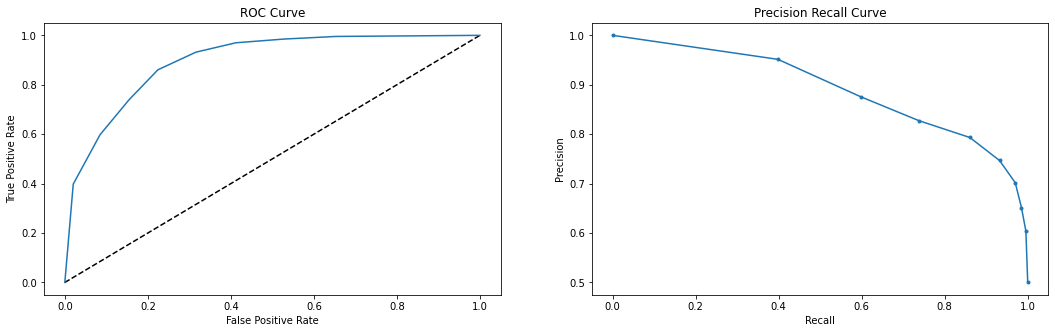

In [74]:
dataplot.curves(X_test, y_test, kNN)

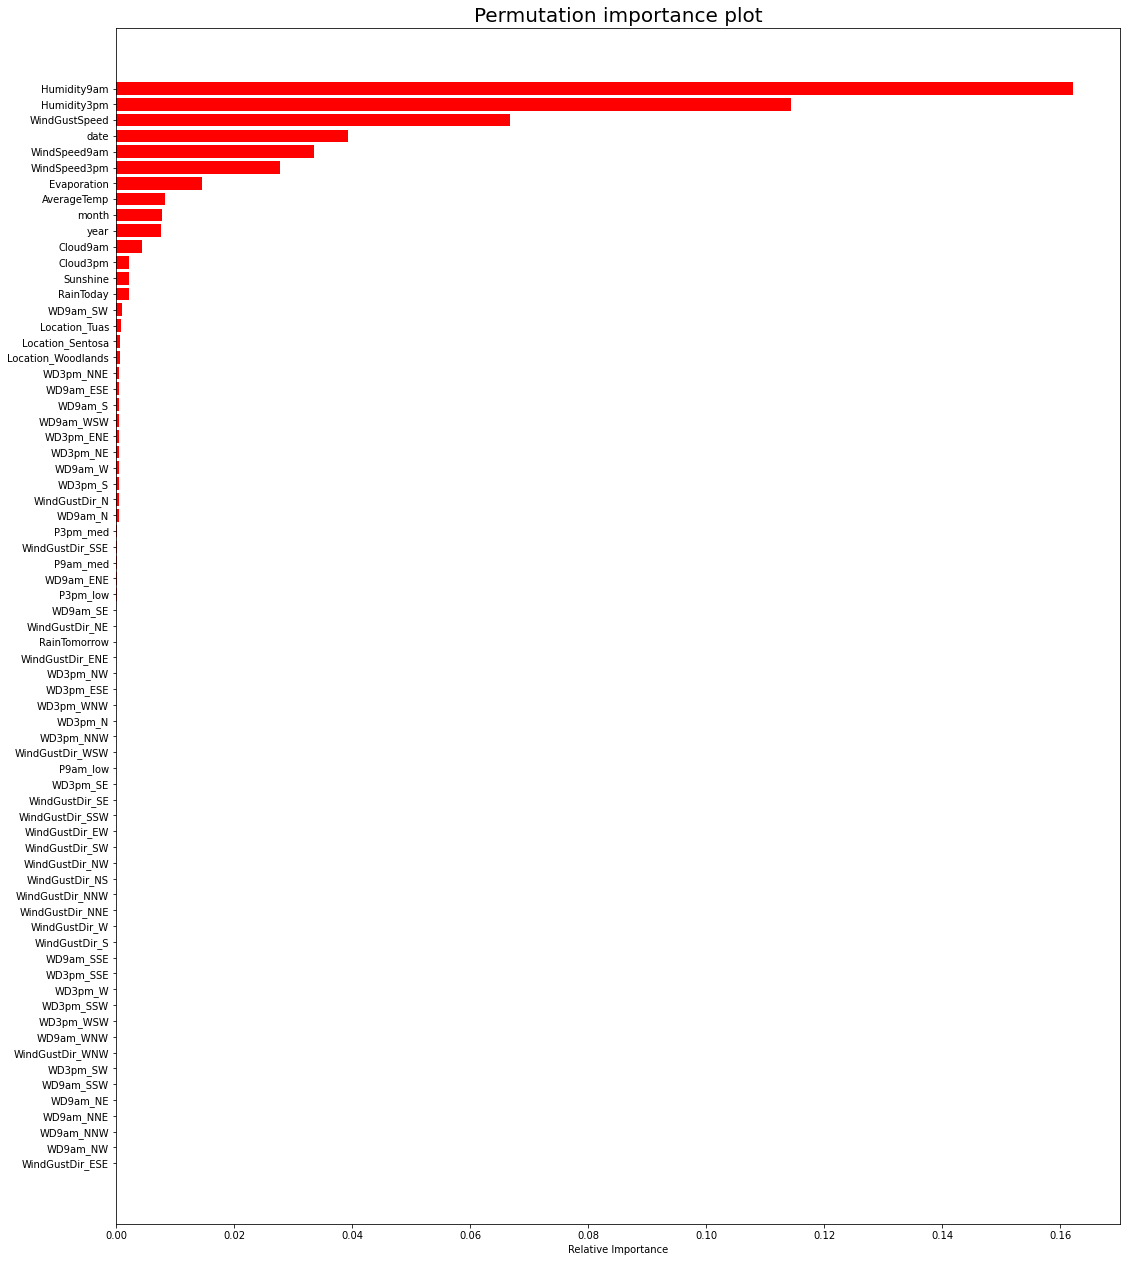

In [75]:
results = permutation_importance(kNN, X_test, y_test, scoring='accuracy')

dataplot.permutation(X_test, results)

Observations:

Humidity9am in first place as most predictive variable, followed by Humidity3pm at number 2 spot, WindGustSpeed ranking 3rd., date 4th. WindSpeed9am and WindSpeed3pm are neck-to-neck in 5th/6th places.

### Conclusion:

Going by the feature/permutation importance plots, Humidity9am appears to be the most consequential attribute in determining likelihood of rain the following day as it is the only variable with high predictive rankings in the logistic regression, Adaboost and k-nearest neighbour plots.

WindGustSpeed appears to be another consequential variable after Humidity9am as it also ranks highly in all the plots with the exception of Logistic Regression with RFECV, where it ranks close to the bottom. In the Logistic Regression with RFECV, WindSpeed3pm ranks first, and also ranks 5th/6th place in the kNN plot. However, it must be noted that it is a correlated variable with WindGustSpeed as assessed by the Spearman correlation plot.

Having said that, this does not imply that other attributes have no predictive value in determining whether it will rain tomorrow, although it appears that they have lesser predictive value as compared to Humidity9am and WindGustSpeed, based on the reading of their rankings in the feature/permutation importance plot. Nevertheless it can be fairly safe to assume that some variables do appear to have very little to no predictive value, such as P9am low, RainTomorrow as they rank very low in the feature/permutation importance plot and appear to have dropped out of the rankings after RFECV is performed.
